In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [2]:
dirPath = "data preprocessed"

means, stds = eval(open(dirPath + "\\means_and_stds_about_trainset.py").read())

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((33600, 18), (14400, 18), (12000, 17))

划分数据集特征和标签：

In [3]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]
trainSet.shape, validateSet.shape

((33600, 17), (14400, 17))

由于PLA的分类标签为+1和-1，因此要把原来数据集的0标签替换为-1.

In [22]:
trainSetLabel[trainSetLabel == 0.0] = -1.0
validateSetLabel[validateSetLabel == 0.0] = -1.0

Counter(trainSetLabel), Counter(validateSetLabel)

(Counter({-1.0: 17216, 1.0: 16384}), Counter({-1.0: 7377, 1.0: 7023}))

# 实现评测指标

In [89]:
def calcF1(predictLabel, realLabel, printRes=False):
    '''给定算法得到的分类结果和实际的分类结果，计算评测指标
    注意：标签为1则为正标签，标签不为1则为负标签'''
    def safeDivide(a, b):
        '''子函数：当分母为0时返回除式结果为 -1'''
        return a/b if b != 0 else 0
    
    TP = Counter(np.logical_and(predictLabel==1, realLabel==1))[True]
    FN = Counter(np.logical_and(predictLabel!=1, realLabel==1))[True]
    FP = Counter(np.logical_and(predictLabel==1, realLabel!=1))[True]
    if(printRes):
        print("TP FN FP", TP, FN, FP)
    F1 = safeDivide(2*TP, 2*TP+FN+FP)
    return F1

print('test 1: normal one')
calcF1(arr([1, 1, 0, 0]), arr([1, 0, 1, 0]), True)
print('\ntest 2: may have zero division error')
calcF1(arr([0, 0, 1, 0]), arr([1, 0, 1, 0]), True)

test 1: normal one
TP FN FP 1 1 1


0.5


test 2: may have zero division error
TP FN FP 1 1 0


0.6666666666666666

# PLA

In [92]:
class PLA_origin:
    
    def addOne2Samples(self, dataSet):
        '''给每一个样本前加一个常数1'''
        ones = np.ones(len(dataSet))
        dataSet = np.array(dataSet)
        return np.column_stack((ones, dataSet))
    
    def fit(self, trainSet, label, maxRunTimes=100):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        #设置默认的 w 全为1
        self.w = np.ones(trainSet.shape[1]+1)
        #给每一个样本前加一个常数1
        trainSet = self.addOne2Samples(trainSet)
        for i in range(maxRunTimes):
            #遍历所有样本
            for index, sample in enumerate(trainSet):
                #更新预测错误的样本
                if np.sign(np.dot(sample, self.w)) != label[index]:
                    self.w += label[index]*sample
                    
    def apply(self, otherSet):
        '''根据已训练出的 w 对其他数据集进行划分'''
        otherSet = self.addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = np.sign(np.dot(sample, self.w))
        return outputLabel
    
    def getW(self):
        return self.w

class PLA_test(PLA_origin):
    def __init__(self, rumTimeStart=100, runTimeEnd=10000, runTimeStep=100):
        self.rumTimeStart = rumTimeStart
        self.runTimeEnd = runTimeEnd
        self.runTimeStep = runTimeStep
        self.testRange = np.arange(rumTimeStart, runTimeEnd+runTimeStep, runTimeStep)
        
    def fit(self, trainSet, trainSetlabel, validateSet, validateSetLabel):
        '''根据给定的训练集和标签训练PLA的参数 w '''
        #设置默认的 w 全为1
        self.w = np.ones(trainSet.shape[1]+1)
        #给每一个样本前加一个常数1
        train = self.addOne2Samples(trainSet)
        validate = self.addOne2Samples(validateSet)
        F1s = []
        for i in tnrange(1, self.runTimeEnd+1):
            #遍历所有样本
            for index, sample in enumerate(train):
                #更新预测错误的样本
                if np.sign(np.dot(sample, self.w)) != trainSetlabel[index]:
                    self.w += trainSetlabel[index]*sample
            #在验证集上测试
            if i%self.runTimeStep == 0:
                ansLabel = self.apply(validate)
                F1s.append(calcF1(ansLabel, validateSetLabel))
        return F1s
               
    def apply(self, otherSet):
        '''根据已训练出的 w 对其他数据集进行划分'''
        #otherSet = self.addOne2Samples(otherSet)
        outputLabel = np.zeros(otherSet.shape[0])
        for index, sample in enumerate(otherSet):
            outputLabel[index] = np.sign(np.dot(sample, self.w))
        return outputLabel            
############测试程序###################
a = [[-4, -1], [0, 3]] # trainSet
b = [1,-1]             # label
e = [[-2, 3]]          # otherSet

p = PLA_origin() # 得到PLA类
p.fit(arr(a), arr(b), maxRunTimes=10)      # 给定的训练集和标签，训练PLA的参数 w
print("最终训练得到的参数 w 为：", p.getW())  
print("对测试数据集 %s 划分的结果为： %s " %(e, p.apply(arr(e))))
############测试程序###################

最终训练得到的参数 w 为： [ 1. -3. -3.]
对测试数据集 [[-2, 3]] 划分的结果为： [-1.] 


# 调参

所调参数只有迭代次数。

In [93]:
pla_test = PLA_test()
pla_test.testRange
len(pla_test.testRange)

array([  100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,  1800,
        1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,  2700,
        2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,  3600,
        3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,  4500,
        4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,  5400,
        5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,  6300,
        6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,  7200,
        7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,  8100,
        8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,  9000,
        9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,  9900, 10000])

100

In [94]:
ansF1s = pla_test.fit(trainSet, trainSetLabel, validateSet, validateSetLabel)    

In [95]:
bestRuntime = pla_test.testRange[np.argmax(ansF1s)]
bestRuntime, np.max(ansF1s)

(3600, 0.66703910614525141)

In [96]:
InteractiveShell.ast_node_interactivity = "none"

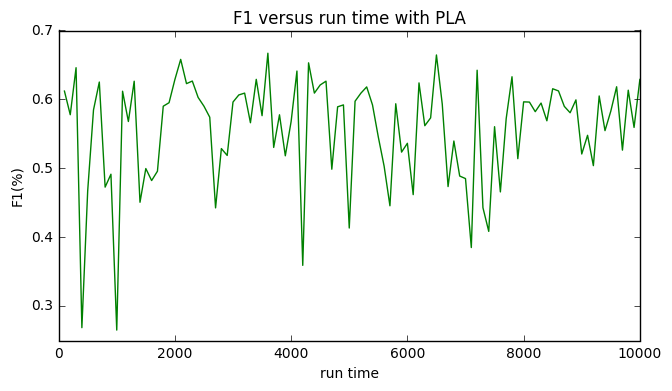

In [97]:
fig,ax = plt.subplots() 
fig.set_size_inches(7.5, 4)
plt.plot(pla_test.testRange, ansF1s, 'g')
plt.xlabel('run time')
plt.ylabel('F1(%)')
plt.title("F1 versus run time with PLA")
plt.show()
plt.close()

In [98]:
InteractiveShell.ast_node_interactivity = "all"

# 应用算法到测试集

In [64]:
bestPLA = PLA_origin()
bestPLA.fit(trainSet, trainSetLabel, maxRunTimes=bestRuntime)
ansLabel = bestPLA.apply(testSet)
ansLabel[ansLabel == -1.0] = 0.0 #记得要把-1标签转为0
np.savetxt('.\\rank\\47_v2.csv', ansLabel, fmt="%d", delimiter="\n")

In [68]:
Counter(ansLabel)
one = Counter(ansLabel)[1.0]
zero = Counter(ansLabel)[0.0]
one/(one + zero)

Counter({0.0: 6585, 1.0: 5415})

0.45125